# Ex 13: Kuiper belt object interception

We are focusing on intercepting $1994GV_9$. We are assuming that the asteroid is evolving on the same plane as the earth (the eccliptic) and orbiting the sun at 43.6AU in a circular motion.

In [308]:
import matplotlib.pyplot as plt

from space_base import GravBody, Probe
import numpy as np

# Define constants
G = 6.67e-11  # Gravitational constant
g0 = 9.80665
sun = GravBody(name="Sun", mass=1_988_500e24, radius=695_700e3)  # Sun as an object with mass and radius

# Define conversion function
def AU_to_meters(UA):
    return UA * 1.496e11
def meters_to_AU(meters):
    return meters / 1.496e11

## Long duration burn simulation

To be more realistic with our ion rocket, we are not going to simulate an impulsive burn but a continuous burn. For that, the differential function use to simulate the probe needs some changes.

Z and vz will be used to store the mass of the probe as space_base do not support 4D inputs.

In [309]:
mass_lost_rate = 10e-6 # kg/s
dry_mass = 300 # dry mass of the probe
def probeqns_rocket(_, posvelmass):
    Isp = 3400 # in seconds
    if posvelmass[2] <= dry_mass:
        posvelmass[5] = 0.0
    else:
        posvelmass[5] = -mass_lost_rate

    r = np.sqrt(posvelmass[0] ** 2 + posvelmass[1] ** 2)
    f = -G * sun.mass / r ** 3
    gravity_force = f * posvelmass[0:2]
    axy = gravity_force + posvelmass[3:5]*np.abs(posvelmass[5])*g0*Isp/(posvelmass[2]*np.linalg.norm(posvelmass[3:5]))

    return posvelmass[3], posvelmass[4], posvelmass[5], axy[0], axy[1], 0.0

We then initialize our probe at Earth's orbit around the sun as the L4 point is on this orbit.

In [310]:
fuel_mass = 1000 # kg
v0 = np.sqrt(G * sun.mass / AU_to_meters(1))  # initial speed
xymass0 = [AU_to_meters(1), 0, dry_mass + fuel_mass]  # start position
vxy0 = [0, v0]  # start vertical speed
tf = fuel_mass/mass_lost_rate  # Max burn time

probe = Probe(probeqns_rocket, tf, tf/3600, x0=xymass0[0], vx0=vxy0[0], 
            y0=xymass0[1], vy0=vxy0[1], z0=xymass0[2], vz0=mass_lost_rate) # probe as an object
t, posvel = probe.odesolve() # solve the differential equations

This is the probe trajectory at the end of the burn:

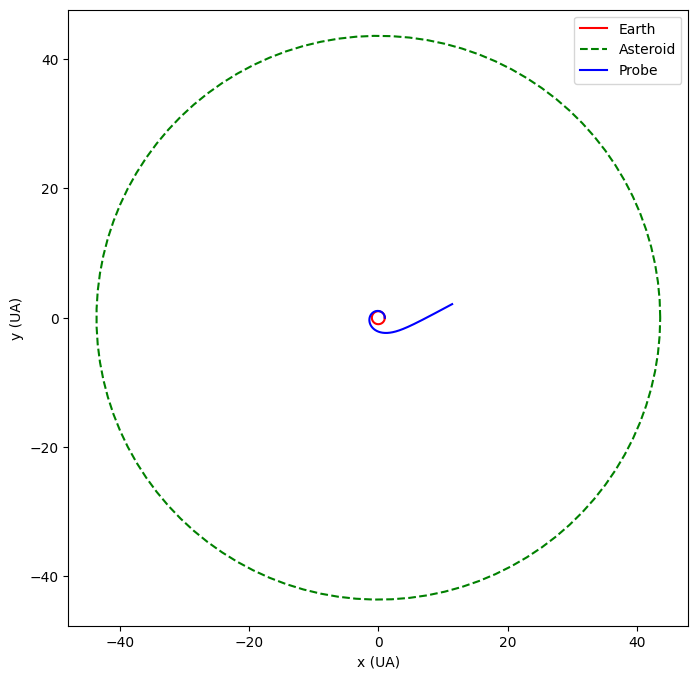

In [311]:
plt.figure(figsize=(8, 8))  # create figure, figsize can be changed as preferred

# Plotting Earth's orbit
uang = np.linspace(0, 2 * np.pi, 100)
x = np.cos(uang)
y = np.sin(uang)
plt.plot(x, y, color='red', label='Earth')
# Plotting Asteroid's orbit
uang = np.linspace(0, 2 * np.pi, 100)
x = 43.6 * np.cos(uang)
y = 43.6 * np.sin(uang)
plt.plot(x, y, color='green', linestyle="--", label='Asteroid')

plt.plot(meters_to_AU(posvel[:, 0]), meters_to_AU(posvel[:, 1]), color='blue', label="Probe") # plot the probe's orbit

plt.xlabel('x (UA)')
plt.ylabel('y (UA)')
plt.axis('equal')
plt.legend()
plt.show() # make plot appear

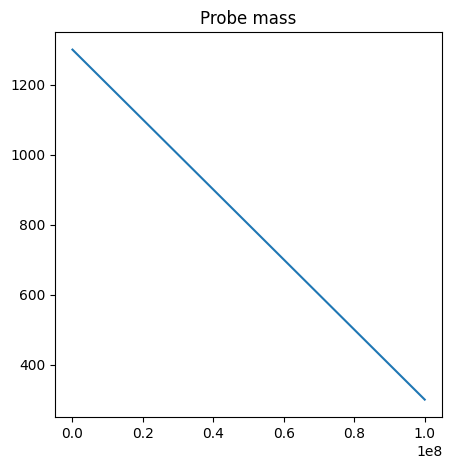

In [312]:
plt.figure(figsize=(5, 5))  # create figure, figsize can be changed as preferred
plt.title("Probe mass")
plt.plot(t, posvel[:, 2])
plt.show()

## Fuel calculation

As the starting amount of fuel will determine the final orbit the probe will reach, it is important to tune this parameter so that our probe reach the desired orbit. For that, we will explore two possible solutions. In these two case, we will use a loop that will find the right starting fuel mass to reach the desire aphelion by interactively interpolate between previous know solution to try converging faster.

### Minimum fuel mass

The first solution could be to try making the smallest burn possible so that after it the probe will settle in a ecliptical orbit with an apoapsis matching the asteroid's orbit. It is the burn that will use the less fuel because we only burn to raise our orbit high enough to reach the asteroid but not more.

In [313]:
import pandas as pd

def probeqns(_, posvel):
    r = np.sqrt(posvel[0] ** 2 + posvel[1] ** 2)
    f = -G * sun.mass / r ** 3
    gravity_force = f * posvel[0:2]
    axy = gravity_force

    return posvel[2], posvel[3], axy[0], axy[1]

dist_to_sun = 1
fuel_mass_dist_cache = pd.DataFrame({'d': [1.0, 500.0], 'dry_mass': [0, 500]})
fuel_mass_dist_cache.set_index('d', inplace=True)
while np.abs(dist_to_sun - 43.6) >= 0.01:
    v0 = np.sqrt(G * sun.mass / AU_to_meters(1))  # initial speed
    fuel_mass = np.interp(43.6, fuel_mass_dist_cache.index, fuel_mass_dist_cache["dry_mass"])
    xymass0 = [AU_to_meters(1), 0, dry_mass + fuel_mass]  # start position
    vxy0 = [0, v0]  # start vertical speed
    tf = fuel_mass/mass_lost_rate  # Max burn time

    probe = Probe(probeqns_rocket, tf, tf/3600, x0=xymass0[0], vx0=vxy0[0], 
                y0=xymass0[1], vy0=vxy0[1], z0=xymass0[2], vz0=mass_lost_rate) # probe as an object
    t, posvel = probe.odesolve() # solve the differential equations

    last_v = np.linalg.norm(posvel[-1, 3:5])
    last_r = np.linalg.norm(posvel[-1, 0:2])
    a = np.abs(G * sun.mass / (last_v ** 2 - 2*G*sun.mass/last_r))

    period = np.sqrt(4 * np.pi**2 * np.abs(a)**3 / (G * sun.mass))/2  # Orbital period
    probe = Probe(probeqns, period, period/3600, x0=posvel[-1, 0], vx0=posvel[-1, 3],
                y0=posvel[-1, 1], vy0=posvel[-1, 4]) # probe as an object
    t_after, posvel_after = probe.odesolve() # solve the differential equations

    dist_to_sun = meters_to_AU(max(np.linalg.norm(posvel_after[:, 0:2], axis=1)))
    new_data = {'d': dist_to_sun, 'dry_mass': dry_mass}
    fuel_mass_dist_cache.loc[dist_to_sun] = fuel_mass
    fuel_mass_dist_cache = fuel_mass_dist_cache.sort_index()

fuel_mass # Fuel mass of the probe to reach the asteroid in kg

147.06252817521252

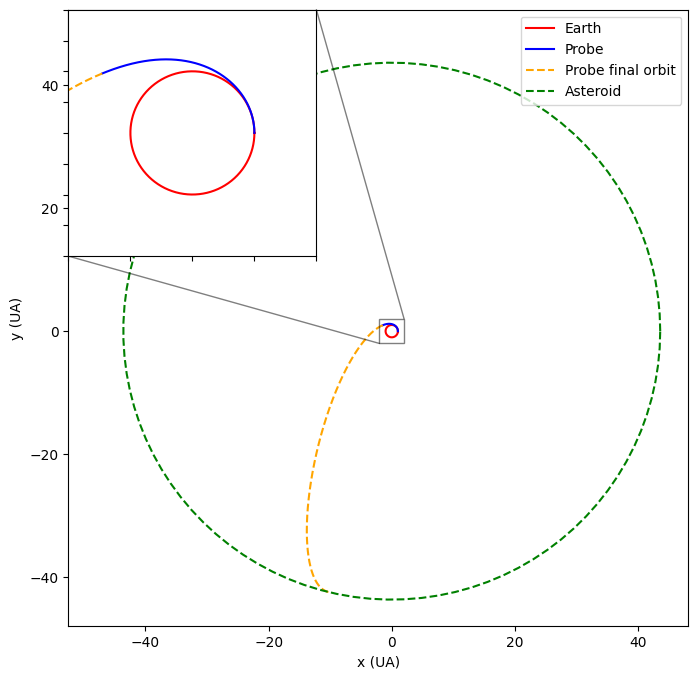

In [314]:
fig = plt.figure(figsize=(8, 8))  # create figure, figsize can be changed as preferred
ax = fig.add_subplot(111)

# Plotting Earth's orbit
uang = np.linspace(0, 2 * np.pi, 100)
x = np.cos(uang)
y = np.sin(uang)
ax.plot(x, y, color='red', label='Earth')

ax.plot(meters_to_AU(posvel[:, 0]), meters_to_AU(posvel[:, 1]), color='blue', label="Probe") # plot the probe's orbit

# Plot probe's final orbit
ax.plot(meters_to_AU(posvel_after[:, 0]), meters_to_AU(posvel_after[:, 1]), color='orange', label='Probe final orbit', linestyle="--")

# inset axes....
box_size = 2
x1, x2, y1, y2 = -box_size, box_size, -box_size, box_size  # subregion of the original image
axins = ax.inset_axes(
    [0, 0.6, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.plot(x, y, color='red', label='Earth')
axins.plot(meters_to_AU(posvel[:, 0]), meters_to_AU(posvel[:, 1]), color='blue', label="Probe") # plot the probe's orbit
axins.plot(meters_to_AU(posvel_after[:, 0]), meters_to_AU(posvel_after[:, 1]), color='orange', label='Probe final orbit', linestyle="--")

# Plotting Asteroid's orbit
uang = np.linspace(0, 2 * np.pi, 100)
x = 43.6 * np.cos(uang)
y = 43.6 * np.sin(uang)
ax.plot(x, y, color='green', linestyle="--", label='Asteroid')

ax.indicate_inset_zoom(axins, edgecolor="black")
ax.set_xlabel('x (UA)')
ax.set_ylabel('y (UA)')
ax.axis('equal')
ax.legend(loc="upper right")
plt.show() # make plot appear

In [315]:
dist_to_sun = np.linalg.norm(posvel_after[:, 0:2], axis=1)
r_aphelion = np.max(dist_to_sun)
meters_to_AU(r_aphelion) # Aphelion distance in UA

43.59192394818552

In [316]:
a = (1.0 + r_aphelion) / 2
meters_to_AU(a) # semi-major axis of the probe's orbit in UA

21.7959619740961

In [317]:
e = (r_aphelion - 1.0) / (r_aphelion + 1.0)
e # eccentricity of the probe's orbit

0.9999999999996934

In [318]:
(t_after[-1] + t[-1]) / (365*24*3600) # Total time to reach the asteroid in years

53.48736974572454

This type of burn (almost like an Hohmann transfer) is indeed really cheap on fuel mass. The fuel needed is lower than the probe dry mass. However, it is extremely slow.

### Fastest journey

To address the travel time problem with the previous burn, it is possible to try another approach and end the burn only when the probe reaches the asteroid's orbit.

In [319]:
dist_to_sun = 1
fuel_mass_dist_cache = pd.DataFrame({'d': [1.0, 500.0], 'dry_mass': [0, 100000]})
fuel_mass_dist_cache.set_index('d', inplace=True)
while np.abs(dist_to_sun - 43.6) >= 0.01:
    v0 = np.sqrt(G * sun.mass / AU_to_meters(1))  # initial speed
    fuel_mass = np.interp(43.6, fuel_mass_dist_cache.index, fuel_mass_dist_cache["dry_mass"])
    xymass0 = [AU_to_meters(1), 0, dry_mass + fuel_mass]  # start position
    vxy0 = [0, v0]  # start vertical speed
    tf = fuel_mass/mass_lost_rate  # Max burn time

    probe = Probe(probeqns_rocket, tf, tf/3600, x0=xymass0[0], vx0=vxy0[0], 
                y0=xymass0[1], vy0=vxy0[1], z0=xymass0[2], vz0=mass_lost_rate) # probe as an object
    t, posvel = probe.odesolve() # solve the differential equations

    dist_to_sun = meters_to_AU(max(np.linalg.norm(posvel[:, 0:2], axis=1)))
    new_data = {'d': dist_to_sun, 'dry_mass': dry_mass}
    fuel_mass_dist_cache.loc[dist_to_sun] = fuel_mass
    fuel_mass_dist_cache = fuel_mass_dist_cache.sort_index()

fuel_mass # Fuel mass of the probe to reach the asteroid in kg

3399.801033121058

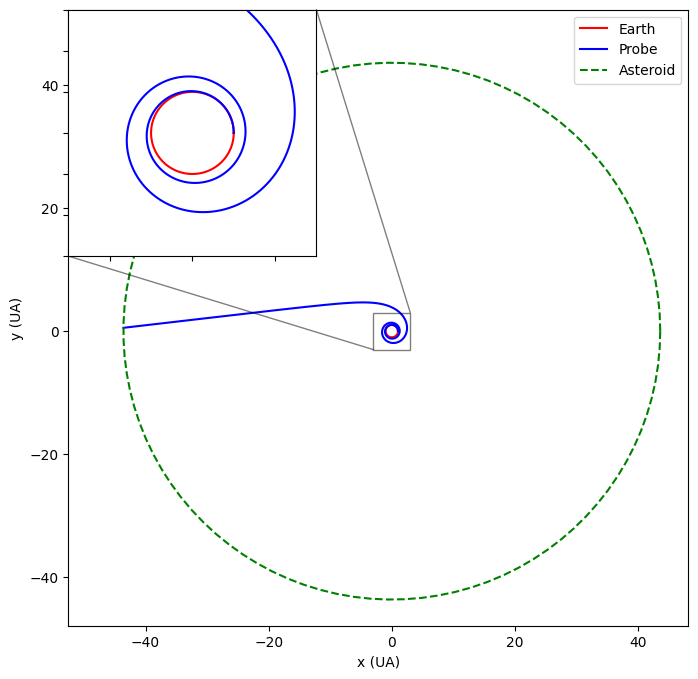

In [320]:
fig = plt.figure(figsize=(8, 8))  # create figure, figsize can be changed as preferred
ax = fig.add_subplot(111)

# Plotting Earth's orbit
uang = np.linspace(0, 2 * np.pi, 100)
x = np.cos(uang)
y = np.sin(uang)
ax.plot(x, y, color='red', label='Earth')

ax.plot(meters_to_AU(posvel[:, 0]), meters_to_AU(posvel[:, 1]), color='blue', label="Probe") # plot the probe's orbit

# inset axes....
box_size = 3
x1, x2, y1, y2 = -box_size, box_size, -box_size, box_size  # subregion of the original image
axins = ax.inset_axes(
    [0, 0.6, 0.4, 0.4],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.plot(x, y, color='red', label='Earth')
axins.plot(meters_to_AU(posvel[:, 0]), meters_to_AU(posvel[:, 1]), color='blue', label="Probe") # plot the probe's orbit

# Plotting Asteroid's orbit
uang = np.linspace(0, 2 * np.pi, 100)
x = 43.6 * np.cos(uang)
y = 43.6 * np.sin(uang)
ax.plot(x, y, color='green', linestyle="--", label='Asteroid')

ax.indicate_inset_zoom(axins, edgecolor="black")
ax.set_xlabel('x (UA)')
ax.set_ylabel('y (UA)')
ax.axis('equal')
ax.legend(loc="upper right")
plt.show() # make plot appear

The resulting orbit as an interesting shape. As the fuel mass decrease the acceleration gain by the probe is higher. This is why the trajectory forms a spiral, as times pass the mass decrease and the acceleration increase.

To determine the final orbit characteristic we can use the energy formula to find the semi-major axis:

$$E=\frac{1}{2}mV^2-\frac{GM_{sun}m}{r}=-\frac{GM_{sun}m}{2a}$$
$$a=\frac{rGM_{sun}}{2GM_{sun}-rV^2}$$

In [321]:
v_final = np.linalg.norm(posvel[-1, 2:4])
v_final / 1e3 # Final speed of the probe in km/s (after burning all fuel)

75.14672173003704

In [322]:
dist_to_sun = np.linalg.norm(posvel[:, 0:2], axis=1)
a = dist_to_sun[-1]*G*sun.mass / (2*G*sun.mass - dist_to_sun[-1]*v_final**2)
meters_to_AU(a) # semi-major axis of the probe's orbit in UA

-0.1581389242707825

To find the Eccentricity we can use the norm of the Eccentricity vector:

$$e=\frac{V\times(r\times V)}{GM_{sun}}-\frac{r}{|r|}$$

In [323]:
pos3d = np.hstack([posvel[-1, 0:2], [0]])
vel3d = np.hstack([posvel[-1, 2:4], [0]])
e = np.linalg.norm(np.cross(vel3d, np.cross(pos3d, vel3d))/(G*sun.mass) - pos3d/dist_to_sun[-1])
e

276.6707886577895

The semi-major axis is negative and the eccentricity is above 1 meaning that the trajectory is hyperbolic. This hyperbolic trajectory suggests that the probe has a velocity greater than the escape velocity which can be verified.

In [324]:
np.sqrt(2*G*sun.mass / dist_to_sun[-1]) / 1e3 # Escape speed at the probe position in km/s

6.377211973108335

In [325]:
t[-1] / (365*24*3600) # Total time to reach the asteroid in years

10.780698354645669

Even if the fuel consumption is way greater, the travel time has been drastically improved. But the two values does not evolve linearly, indeed, the time have been cut-off be almost 5 but the fuel mass has been multiplied by 20. Furthermore, the probe has also accumulated a great velocity, therefore, to stay into orbit at arrival the slowdown burn would be really expensive.

One better solution could be to average these two previous solution and also use a slingshot manoeuvre from Jupiter or Mars to help the probe gain velocity without using too much fuel. This also allows to reduce the travel time.